In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
fear_greed_df = pd.read_csv('fear_greed_index.csv')

In [3]:
trading_df = pd.read_csv('historical_data.csv')

In [4]:
print("\n Fear & Greed Index Dataset:")
print(fear_greed_df.head())
print(f"\nColumns: {list(fear_greed_df.columns)}")
print(f"Date range: {fear_greed_df['date'].min()} to {fear_greed_df['date'].max()}")
print(f"Sentiment distribution:\n{fear_greed_df['classification'].value_counts()}")


 Fear & Greed Index Dataset:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Columns: ['timestamp', 'value', 'classification', 'date']
Date range: 2018-02-01 to 2025-05-02
Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [6]:
print("\n Trading Dataset:")
print(trading_df.head())
print(f"\nColumns: {list(trading_df.columns)}")
print(f"Unique traders: {trading_df['Account'].nunique()}")
print(f"Coins traded: {trading_df['Coin'].nunique()}")
print(f"Total trades: {len(trading_df)}")


 Trading Dataset:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0   

In [7]:
# Clean Fear & Greed data
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df['value'] = pd.to_numeric(fear_greed_df['value'], errors='coerce')

# Clean Trading data
trading_df['Timestamp IST'] = pd.to_datetime(trading_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trading_df['date'] = trading_df['Timestamp IST'].dt.date
trading_df['Execution Price'] = pd.to_numeric(trading_df['Execution Price'], errors='coerce')
trading_df['Size USD'] = pd.to_numeric(trading_df['Size USD'], errors='coerce')
trading_df['Closed PnL'] = pd.to_numeric(trading_df['Closed PnL'], errors='coerce')
trading_df['Fee'] = pd.to_numeric(trading_df['Fee'], errors='coerce')

In [8]:
# Remove rows with missing critical data
trading_df = trading_df.dropna(subset=['Timestamp IST', 'Closed PnL', 'Size USD'])
fear_greed_df = fear_greed_df.dropna(subset=['date', 'value'])

In [9]:
print(f"Cleaned trading data: {len(trading_df)} rows")
print(f"Cleaned sentiment data: {len(fear_greed_df)} rows")

Cleaned trading data: 211224 rows
Cleaned sentiment data: 2644 rows


In [10]:
# Daily trading metrics
daily_trading = trading_df.groupby('date').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'Fee': 'sum',
    'Account': 'nunique'
}).round(2)

daily_trading.columns = ['total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'total_fees', 'unique_traders']
daily_trading = daily_trading.reset_index()
daily_trading['date'] = pd.to_datetime(daily_trading['date'])

In [11]:
daily_trading.head()

,date,total_pnl,avg_pnl,trade_count,total_volume,total_fees,unique_traders
0,2023-05-01,0.00,0.00,3,477.00,0.00,1
1,2023-12-05,0.00,0.00,9,50005.83,12.50,1
2,2023-12-14,-205.43,-18.68,11,113203.35,28.30,1
3,2023-12-15,-24.63,-12.32,2,10609.95,2.65,1
4,2023-12-16,0.00,0.00,3,15348.77,3.84,1


In [12]:
# Calculate win rate
trading_df['is_profitable'] = trading_df['Closed PnL'] > 0
daily_win_rate = trading_df.groupby('date')['is_profitable'].mean().reset_index()
daily_win_rate.columns = ['date', 'win_rate']
daily_win_rate['date'] = pd.to_datetime(daily_win_rate['date'])

daily_trading = pd.merge(daily_trading, daily_win_rate, on='date', how='left')

In [14]:
daily_win_rate.head(10)

,date,win_rate
0,2023-05-01,0.000000
1,2023-12-05,0.000000
2,2023-12-14,0.363636
3,2023-12-15,0.000000
4,2023-12-16,0.000000
5,2023-12-17,0.500000
6,2023-12-18,0.000000
7,2023-12-19,0.666667
8,2023-12-20,0.444444
9,2023-12-21,0.530612


In [15]:
# Merge with sentiment data
daily_sentiment = fear_greed_df.groupby('date').agg({
    'value': 'mean',
    'classification': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()

# Merge datasets
merged_data = pd.merge(daily_trading, daily_sentiment, on='date', how='inner')
print(f" Merged dataset: {len(merged_data)} days with both trading and sentiment data")


 Merged dataset: 479 days with both trading and sentiment data


In [18]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# 1. Sentiment classification distribution
sentiment_counts = fear_greed_df['classification'].value_counts().reset_index()
sentiment_counts.columns = ['classification', 'count']

fig1 = px.pie(
    sentiment_counts,
    names='classification',
    values='count',
    title=' Market Sentiment Distribution',
    color_discrete_sequence=['#ff4444', '#ff8800', '#ffdd00', '#88dd00', '#00dd88']
)
fig1.update_traces(textinfo='percent+label', hoverinfo='label+percent+value')

# 2. Fear & Greed Index histogram
fig2 = px.histogram(
    fear_greed_df,
    x='value',
    nbins=20,
    title=' Fear & Greed Index Distribution',
    color_discrete_sequence=['skyblue']
)
fig2.add_vline(x=fear_greed_df['value'].mean(), line_dash="dash", line_color="red",
               annotation_text=f"Mean: {fear_greed_df['value'].mean():.1f}", annotation_position="top right")

# 3. Average Trading Volume by Sentiment
sentiment_volume = merged_data.groupby('classification')['total_volume'].mean().sort_values().reset_index()

fig3 = px.bar(
    sentiment_volume,
    x='total_volume',
    y='classification',
    orientation='h',
    title=' Average Trading Volume by Sentiment',
    color='classification',
    color_discrete_sequence=['#ff4444', '#ff8800', '#ffdd00', '#88dd00', '#00dd88']
)
fig3.update_traces(text=sentiment_volume['total_volume'].map(lambda x: f"${x:,.0f}"), textposition='outside')
fig3.update_layout(yaxis=dict(categoryorder='total ascending'))

# 4. Average Daily PnL by Sentiment
sentiment_pnl = merged_data.groupby('classification')['total_pnl'].mean().sort_values().reset_index()
sentiment_pnl['color'] = sentiment_pnl['total_pnl'].apply(lambda x: 'green' if x >= 0 else 'red')

fig4 = go.Figure()

fig4.add_trace(go.Bar(
    x=sentiment_pnl['total_pnl'],
    y=sentiment_pnl['classification'],
    orientation='h',
    marker_color=sentiment_pnl['color'],
    text=sentiment_pnl['total_pnl'].map(lambda x: f"${x:,.0f}"),
    textposition='outside',
    hovertemplate='Sentiment: %{y}<br>Avg PnL: %{x:$,.2f}<extra></extra>'
))

fig4.add_vline(x=0, line_color='black', line_width=1, opacity=0.4)
fig4.update_layout(title=' Average Daily PnL by Sentiment')


fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [19]:
sentiment_stats = merged_data.groupby('classification').agg({
    'total_pnl': ['mean', 'sum', 'std'],
    'avg_pnl': 'mean',
    'trade_count': 'mean',
    'total_volume': 'mean',
    'unique_traders': 'mean',
    'win_rate': 'mean'
}).round(2)

print("Average metrics by market sentiment:")
print(sentiment_stats)

Average metrics by market sentiment:
               total_pnl                        avg_pnl trade_count  \
                    mean         sum        std    mean        mean   
classification                                                        
Extreme Fear    52793.59   739110.24  101262.40   38.43     1528.57   
Extreme Greed   23817.29  2715171.34   72827.30   56.74      350.81   
Fear            36891.82  3357155.42   96611.85   31.28      679.53   
Greed           11140.57  2150129.31   62427.96   39.41      260.64   
Neutral         19297.32  1292920.67   37995.21   63.82      562.48   

               total_volume unique_traders win_rate  
                       mean           mean     mean  
classification                                       
Extreme Fear     8177447.25          11.43     0.33  
Extreme Greed    1091799.69           4.61     0.47  
Fear             5311261.43           6.92     0.33  
Greed            1495246.09           3.36     0.34  
Neutral         


 CORRELATION ANALYSIS


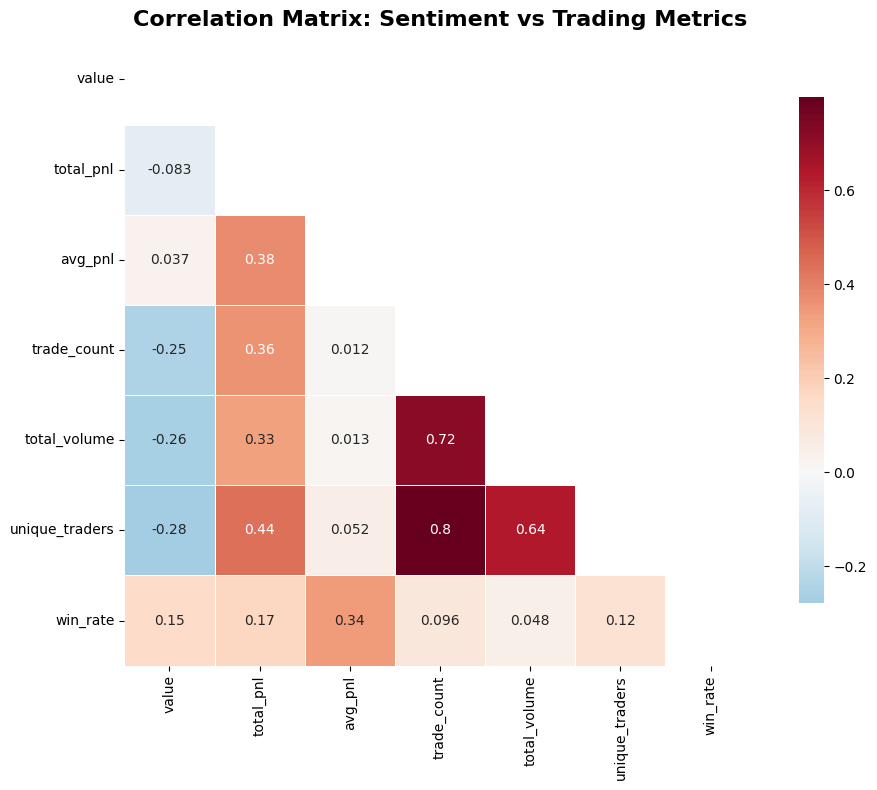

Correlation between Fear & Greed Index and trading metrics:
unique_traders   -0.277510
total_volume     -0.264371
trade_count      -0.245241
win_rate          0.152485
total_pnl        -0.082642
avg_pnl           0.037315
Name: value, dtype: float64


In [21]:
print("\n CORRELATION ANALYSIS")
print("=" * 35)

correlation_cols = ['value', 'total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'unique_traders', 'win_rate']
correlation_matrix = merged_data[correlation_cols].corr()

# Correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Sentiment vs Trading Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation between Fear & Greed Index and trading metrics:")
fear_greed_correlations = correlation_matrix['value'].drop('value').sort_values(key=abs, ascending=False)
print(fear_greed_correlations)

In [23]:
import plotly.express as px
import plotly.graph_objects as go

# Categorize sentiment ranges
def categorize_sentiment(value):
    if value <= 25:
        return 'Extreme Fear (0-25)'
    elif value <= 45:
        return 'Fear (26-45)'
    elif value <= 55:
        return 'Neutral (46-55)'
    elif value <= 75:
        return 'Greed (56-75)'
    else:
        return 'Extreme Greed (76-100)'

merged_data['sentiment_range'] = merged_data['value'].apply(categorize_sentiment)

# --- Time series: PnL and Fear & Greed Index ---
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=merged_data['date'], y=merged_data['total_pnl'],
    mode='lines', name='Daily PnL', line=dict(color='green'),
    yaxis='y1', hovertemplate='Date: %{x}<br>PnL: $%{y:.2f}<extra></extra>'
))

fig1.add_trace(go.Scatter(
    x=merged_data['date'], y=merged_data['value'],
    mode='lines', name='Fear & Greed Index', line=dict(color='red'),
    yaxis='y2', hovertemplate='Date: %{x}<br>Index: %{y:.0f}<extra></extra>'
))

fig1.update_layout(
    title='📈 Daily PnL vs Fear & Greed Index Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='PnL ($)', side='left', color='green'),
    yaxis2=dict(title='Fear & Greed Index', side='right', overlaying='y', range=[0, 100], color='red'),
    hovermode='x unified',
    height=500
)

# --- Average PnL by Sentiment Range ---
sentiment_perf = merged_data.groupby('sentiment_range').agg({
    'total_pnl': 'mean',
    'win_rate': 'mean'
}).round(2).reset_index()

sentiment_perf['base'] = sentiment_perf['sentiment_range'].str.extract(r'(\w+)')
sentiment_perf = sentiment_perf.sort_values('total_pnl')

fig2 = px.bar(
    sentiment_perf,
    x='sentiment_range',
    y='total_pnl',
    color='total_pnl',
    color_continuous_scale=['red', 'orange', 'yellow', 'lightgreen', 'green'],
    title=' Average Daily PnL by Sentiment Range',
    labels={'total_pnl': 'Avg Daily PnL ($)', 'sentiment_range': 'Sentiment Range'},
    text_auto='.2s'
)
fig2.update_traces(textposition='outside')
fig2.update_layout(xaxis_tickangle=-45, height=400)

# --- Win Rate by Sentiment Range ---
fig3 = px.bar(
    sentiment_perf,
    x='sentiment_range',
    y='win_rate',
    title=' Win Rate by Sentiment Range',
    labels={'win_rate': 'Win Rate (%)', 'sentiment_range': 'Sentiment Range'},
    text=sentiment_perf['win_rate'].apply(lambda x: f'{x*100:.1f}%'),
    color_discrete_sequence=['skyblue']
)
fig3.update_traces(textposition='outside')
fig3.update_layout(xaxis_tickangle=-45, height=400)

# --- Scatter: Sentiment Value vs PnL with Trade Count ---
fig4 = px.scatter(
    merged_data,
    x='value',
    y='total_pnl',
    size='trade_count',
    color='trade_count',
    color_continuous_scale='viridis',
    trendline='ols',
    title=' Sentiment vs Daily PnL (Size & Color = Trade Count)',
    labels={'value': 'Fear & Greed Index', 'total_pnl': 'Daily PnL ($)', 'trade_count': 'Trade Count'},
    hover_data=['date']
)
fig4.update_layout(height=500)

# Show all interactive plots (or in Streamlit use st.plotly_chart)
fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [25]:
import plotly.express as px

print("\nANALYSIS 4: TOP TRADERS ANALYSIS")
print("=" * 35)

# Analyze individual trader performance
trader_performance = trading_df.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'Fee': 'sum'
}).round(2)

# Rename columns
trader_performance.columns = ['total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'total_fees']

# Add net_pnl and roi
trader_performance['net_pnl'] = trader_performance['total_pnl'] - trader_performance['total_fees']
trader_performance['roi'] = (trader_performance['net_pnl'] / trader_performance['total_volume'] * 100).round(2)

# Filter traders with at least 10 trades
trader_performance = trader_performance[trader_performance['trade_count'] >= 10]

# Top 10 traders by net PnL
top_traders = trader_performance.nlargest(10, 'net_pnl').reset_index()

# Horizontal bar chart of net PnL
bar_fig = px.bar(
    top_traders,
    x='net_pnl',
    y='Account',
    orientation='h',
    color='net_pnl',
    color_continuous_scale='RdYlGn',
    labels={'net_pnl': 'Net PnL ($)', 'Account': 'Trader'},
    title='Top 10 Traders by Net PnL'
)
bar_fig.update_layout(
    title_font_size=16,
    xaxis_title='Net PnL ($)',
    yaxis_title='Trader',
    yaxis=dict(autorange="reversed")  # Reverse y-axis for descending bar chart
)
bar_fig.show()

# Scatter plot for ROI vs trade count
scatter_fig = px.scatter(
    top_traders,
    x='trade_count',
    y='roi',
    size='total_volume',
    color='net_pnl',
    color_continuous_scale='RdYlGn',
    hover_name='Account',
    labels={
        'trade_count': 'Number of Trades',
        'roi': 'ROI (%)',
        'net_pnl': 'Net PnL ($)',
        'total_volume': 'Total Volume ($)'
    },
    title='Top Traders: ROI vs Trade Count (Bubble Size = Volume)'
)
scatter_fig.update_layout(title_font_size=16)
scatter_fig.show()

# Print table of top traders
print("Top 10 traders by net PnL:")
print(top_traders[['Account', 'net_pnl', 'trade_count', 'roi', 'total_volume']])


ANALYSIS 4: TOP TRADERS ANALYSIS


Top 10 traders by net PnL:
                                      Account     net_pnl  trade_count    roi  \
0  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2127387.28        14733   3.76   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  1592824.51         3818   2.58   
2  0xbaaaf6571ab7d571043ff1e313a9609a10637864   931567.10        21192   1.37   
3  0xbee1707d6b44d4d52bfe19e41f8a828645437aab   822727.65        40184   1.11   
4  0x513b8629fe877bb581bf244e326a047b249c4ff1   763997.92        12236   0.18   
5  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4   669721.06         4356   1.69   
6  0x72743ae2822edd658c0c50608fd7c5c501b2afbd   427804.13         1590   3.73   
7  0x430f09841d65beb3f27765503d0f850b8bce7713   415794.86         1237  14.02   
8  0x72c6a4624e1dffa724e6d00d64ceae698af892a0   402721.49         1430  13.20   
9  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4   376500.15         9893   1.46   

   total_volume  
0  5.654357e+07  
1  6.169726e+07  
2  6.803634e+07  
3  7.4107

In [27]:
import plotly.express as px

print("\nANALYSIS 5: COIN PERFORMANCE ANALYSIS")
print("=" * 35)

# Aggregate coin performance
coin_performance = trading_df.groupby('Coin').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'Account': 'nunique'
}).round(2)

coin_performance.columns = ['total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'unique_traders']

# Filter for coins with at least 10 trades
coin_performance = coin_performance[coin_performance['trade_count'] >= 10]

# Top 15 coins by total PnL
top_coins = coin_performance.nlargest(15, 'total_pnl').reset_index()

# Bar chart for Total PnL
bar_fig = px.bar(
    top_coins,
    x='Coin',
    y='total_pnl',
    color='total_pnl',
    color_continuous_scale='RdYlGn',
    labels={'total_pnl': 'Total PnL ($)'},
    title='Top 15 Coins by Total PnL'
)
bar_fig.update_layout(
    title_font_size=16,
    xaxis_title='Coin',
    yaxis_title='Total PnL ($)',
    xaxis_tickangle=-45
)
bar_fig.add_hline(y=0, line_dash="solid", line_color="black", opacity=0.5)
bar_fig.show()

# Bubble chart: Average PnL vs Trade Count
bubble_fig = px.scatter(
    top_coins,
    x='trade_count',
    y='avg_pnl',
    size='unique_traders',
    color='total_pnl',
    color_continuous_scale='RdYlGn',
    hover_name='Coin',
    labels={
        'trade_count': 'Number of Trades',
        'avg_pnl': 'Average PnL per Trade ($)',
        'unique_traders': 'Unique Traders',
        'total_pnl': 'Total PnL ($)'
    },
    title='Coin Performance: Avg PnL vs Trade Count (Bubble Size = Unique Traders)'
)
bubble_fig.update_layout(
    title_font_size=16,
    xaxis_title='Number of Trades',
    yaxis_title='Average PnL per Trade ($)'
)
bubble_fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)
bubble_fig.show()

# Print table of top coins
print("Top performing coins (min 10 trades):")
print(top_coins.head(10))


ANALYSIS 5: COIN PERFORMANCE ANALYSIS


Top performing coins (min 10 trades):
      Coin   total_pnl  avg_pnl  trade_count  total_volume  unique_traders
0     @107  2783912.92    92.82        29992  5.576086e+07              27
1     HYPE  1948484.60    28.65        68005  1.419902e+08              22
2      SOL  1639555.93   153.36        10691  1.250748e+08              19
3      ETH  1319978.84   118.30        11158  1.182810e+08              22
4      BTC   868044.73    33.30        26064  6.442321e+08              23
5  MELANIA   390351.07    88.16         4428  7.040710e+06               9
6      ENA   217329.50   219.52          990  1.625400e+06               4
7      SUI   199268.83   100.69         1979  7.781168e+06               6
8      ZRO   183777.78   148.33         1239  1.213825e+06               5
9     DOGE   147543.16   178.62          826  2.452103e+06              10


In [31]:
print("\nANALYSIS 6: TIME-BASED PATTERNS")
print("=" * 32)

# Add time features
trading_df['hour'] = trading_df['Timestamp IST'].dt.hour
trading_df['day_of_week'] = trading_df['Timestamp IST'].dt.day_name()

# Aggregate performance by hour and day
hourly_performance = trading_df.groupby('hour')['Closed PnL'].agg(['mean', 'sum', 'count']).round(2).reset_index()
daily_performance = trading_df.groupby('day_of_week')['Closed PnL'].agg(['mean', 'sum', 'count']).round(2)

# Reorder days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_performance = daily_performance.reindex([day for day in day_order if day in daily_performance.index]).reset_index()

# Hourly Average PnL Bar Chart
hourly_fig = px.bar(
    hourly_performance,
    x='hour',
    y='mean',
    color='mean',
    color_continuous_scale='RdYlGn',
    labels={'hour': 'Hour of Day', 'mean': 'Average PnL ($)'},
    title='Average PnL by Hour of Day'
)
hourly_fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=2),
    title_font_size=16,
    yaxis_title='Average PnL ($)'
)
hourly_fig.add_hline(y=0, line_dash="solid", line_color="black", opacity=0.5)
hourly_fig.show()

import plotly.express as px

# Assuming hourly_performance is a DataFrame with 'hour' as index and 'mean' column for average PnL
hourly_performance = hourly_performance.reset_index()

fig = px.line(
    hourly_performance,
    x='hour',
    y='mean',
    markers=True,
    title='Average PnL by Hour of Day',
    labels={'hour': 'Hour of Day', 'mean': 'Average PnL ($)'},
)

# add color for positive/negative values:
fig.update_traces(
    line=dict(color='green'),
    marker=dict(color=hourly_performance['mean'].apply(lambda x: 'green' if x >= 0 else 'red'))
)

# Add horizontal zero line
fig.add_shape(
    type='line',
    x0=0, x1=23,
    y0=0, y1=0,
    line=dict(color='black', dash='dash')
)

fig.show()

# Daily Average PnL Bar Chart
daily_fig = px.bar(
    daily_performance,
    x='day_of_week',
    y='mean',
    color='mean',
    color_continuous_scale='RdYlGn',
    labels={'day_of_week': 'Day of Week', 'mean': 'Average PnL ($)'},
    title='Average PnL by Day of Week'
)
daily_fig.update_layout(
    title_font_size=16,
    yaxis_title='Average PnL ($)',
    xaxis_title='Day of Week'
)
daily_fig.add_hline(y=0, line_dash="solid", line_color="black", opacity=0.5)
daily_fig.show()

# Print top performance stats
print("Best trading hours (by average PnL):")
print(hourly_performance.nlargest(5, 'mean'))

print("\nBest trading days (by average PnL):")
print(daily_performance.nlargest(7, 'mean'))


ANALYSIS 6: TIME-BASED PATTERNS


Best trading hours (by average PnL):
    index  hour    mean        sum  count
12     12    12  131.17  911657.26   6950
7       7     7   83.03  712784.33   8585
11     11    11   76.86  472707.47   6150
10     10    10   61.35  413788.81   6745
8       8     8   58.89  462140.62   7848

Best trading days (by average PnL):
  day_of_week   mean         sum  count
5    Saturday  65.36  1335062.33  20425
6      Sunday  52.92  1064184.65  20110
0      Monday  51.09  1758437.09  34421
4      Friday  50.26  1489035.02  29624
1     Tuesday  47.48  1731385.81  36469
3    Thursday  46.28  1408735.80  30439
2   Wednesday  38.00  1510118.24  39736


In [32]:
import plotly.express as px

print("\nANALYSIS 7: RISK ANALYSIS")
print("=" * 25)

# Calculate risk metrics
merged_data['pnl_volatility'] = merged_data.groupby(merged_data.index // 7)['total_pnl'].transform('std')
merged_data['sharpe_ratio'] = merged_data['total_pnl'] / merged_data['pnl_volatility']

risk_by_sentiment = merged_data.groupby('classification').agg({
    'pnl_volatility': 'mean',
    'sharpe_ratio': 'mean',
    'total_pnl': 'std'
}).round(3)

print("Risk metrics by sentiment:")
print(risk_by_sentiment)

# Prepare data for risk-return plot
sentiment_risk_return = merged_data.groupby('classification').agg({
    'total_pnl': 'mean',
    'pnl_volatility': 'mean',
    'trade_count': 'mean'
}).round(2).reset_index()

# Define colors for sentiments
colors_sentiment = {
    'Extreme Fear': 'red',
    'Fear': 'orange',
    'Neutral': 'yellow',
    'Greed': 'lightgreen',
    'Extreme Greed': 'green'
}

# Add a color column to the DataFrame based on sentiment classification
sentiment_risk_return['color'] = sentiment_risk_return['classification'].map(colors_sentiment).fillna('blue')

# Plotly Express scatter plot
fig = px.scatter(
    sentiment_risk_return,
    x='pnl_volatility',
    y='total_pnl',
    size='trade_count',
    color='classification',
    color_discrete_map=colors_sentiment,
    hover_name='classification',
    size_max=40,
    title='Risk-Return Profile by Market Sentiment<br>(Bubble size = Average Trade Count)',
    labels={
        'pnl_volatility': 'PnL Volatility (Risk)',
        'total_pnl': 'Average Daily PnL (Return)',
        'classification': 'Market Sentiment',
        'trade_count': 'Average Trade Count'
    }
)

# Add horizontal and vertical zero lines
fig.add_shape(type='line',
              x0=0, x1=sentiment_risk_return['pnl_volatility'].max(),
              y0=0, y1=0,
              line=dict(color='black', dash='dash'))

fig.add_shape(type='line',
              x0=0, x1=0,
              y0=sentiment_risk_return['total_pnl'].min(),
              y1=sentiment_risk_return['total_pnl'].max(),
              line=dict(color='black', dash='dash'))

fig.update_layout(
    xaxis=dict(gridcolor='LightGray'),
    yaxis=dict(gridcolor='LightGray')
)

fig.show()


ANALYSIS 7: RISK ANALYSIS
Risk metrics by sentiment:
                pnl_volatility  sharpe_ratio   total_pnl
classification                                          
Extreme Fear        125637.236         0.280  101262.396
Extreme Greed        33333.609         0.838   72827.302
Fear                 43425.508         0.686   96611.848
Greed                20284.167         0.542   62427.958
Neutral              34492.189         0.509   37995.209


In [39]:
from datetime import datetime
from google.colab import files

print("\n KEY INSIGHTS SUMMARY")
print("=" * 25)

insights = []

# Best sentiment for trading
best_sentiment_range = sentiment_performance.loc[sentiment_performance['total_pnl'].idxmax()]
insights.append(f"1. Best sentiment range for trading: {best_sentiment_range.name} with avg daily PnL of ${best_sentiment_range['total_pnl']:,.2f}")

# Correlation strength
strongest_correlation = fear_greed_correlations.abs().idxmax()
correlation_value = fear_greed_correlations[strongest_correlation]
insights.append(f"2. Strongest correlation with sentiment: {strongest_correlation} (r={correlation_value:.3f})")

# Most profitable coin
most_profitable_coin = coin_performance['total_pnl'].idxmax()
coin_profit = coin_performance.loc[most_profitable_coin, 'total_pnl']
insights.append(f"3. Most profitable coin: {most_profitable_coin} with total PnL of ${coin_profit:,.2f}")

# Best trading time
best_hour = hourly_performance['mean'].idxmax()
best_hour_pnl = hourly_performance.loc[best_hour, 'mean']
insights.append(f"4. Best trading hour: {best_hour}:00 with avg PnL of ${best_hour_pnl:.2f}")

# Risk-adjusted returns
best_risk_sentiment = risk_by_sentiment['sharpe_ratio'].idxmax()
insights.append(f"5. Best risk-adjusted returns during: {best_risk_sentiment} periods")

# Win rate insight
best_winrate_sentiment = sentiment_performance['win_rate'].idxmax()
best_winrate_value = sentiment_performance.loc[best_winrate_sentiment, 'win_rate']
insights.append(f"6. Highest win rate during: {best_winrate_sentiment} ({best_winrate_value:.1%})")

# Print insights
for insight in insights:
    print(insight)

print(f"\n Analysis complete! Processed {len(trading_df):,} trades across {len(merged_data)} days")

# Save to Markdown-style .txt file
summary_text = "\n".join(insights)
summary_text += f"\n\n_Analysis complete! Processed `{len(trading_df):,}` trades across `{len(merged_data)}` days._"

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"key_insights_summary_{timestamp}.txt"

with open(filename, 'w') as f:
    f.write(summary_text)

files.download(filename)


 KEY INSIGHTS SUMMARY
1. Best sentiment range for trading: Extreme Fear (0-25) with avg daily PnL of $49,495.93
2. Strongest correlation with sentiment: unique_traders (r=-0.278)
3. Most profitable coin: @107 with total PnL of $2,783,912.92
4. Best trading hour: 12:00 with avg PnL of $131.17
5. Best risk-adjusted returns during: Extreme Greed periods
6. Highest win rate during: Extreme Greed (76-100) (47.0%)

 Analysis complete! Processed 211,224 trades across 479 days


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>